# Analysis of consumer behaviour in "Unnecessary things" mobile app

#### Additional materials (in Russian):

Tableau Dashboard: https://public.tableau.com/views/Final_project_16512182241420/sheet3?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link

Presentation: https://disk.yandex.ru/d/IEEpraohosMHtA


The purpose of our project is to analyse the consumer behaviour in the "Unnecessary things" mobile app based on datasets `mobile_dataset.csv` and `mobile_soures.csv` which contain information about users who performed any actions in the mobile app since October 7th, 2019.

The mobile app developers introduced a new feature that allows seeing the contatcs list (`contacts_show`) and we will use it as a key feature. In the process of our analysis, we will determine the influence of other steps on the key feature; we will see what other steps did the user perform along with the key one, and we will text two hypotheses. Our project is divided into the following parts:

<a href='#1'> 1. Data preprocessing </a>

<a href='#2'> 2. Data analysis </a>

2.1 What are the download sources?

2.2 What steps can users perform in the app?

2.3 What is the average and median session duration? 

2.4 How many users performed the key feature event? What percentage of the total amount of users do they comprise? 

2.5 Calculation of retention rate, DAU\WAU for the key feature;

<a href='#3'> 3. Analysis of `contacts_show` key feature </a>

3.1 What other steps do users that performed the key feature step perform?

3.2 What steps do the users perform before the key feature step (what are the scenarios of app usage)?

3.3 After how much time after the last step from p.3.2 is the key feature step performed?

<a href='#4'> 4. Hypothesis test </a>

4.1 Conversion to see contacts is different among users who perform both `tips_show` and `tips_click`  and users who only perform `tips_show`.

4.2 Conversion to see contacts is different among users who downloaded the app from `yandex` source and `google` source.

<a href='#5'> 5. Conclusion </a>

<a id='1'></a> 
### 1. Data preprocessing

In [1]:
#import libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [5]:
#load the data and study the general information about the dataset
mobile_dataset = pd.read_csv('/Users/anaitagadzhanyan/Desktop/Практикум/Финальный спринт/mobile_dataset.csv')
mobile_sources = pd.read_csv('/Users/anaitagadzhanyan/Desktop/Практикум/Финальный спринт/mobile_sources.csv')

#lets standartize the column names
mobile_sources.rename(columns = {'userId':'user.id'}, inplace = True)

#put the date column to the right format
mobile_dataset['event.time'] = mobile_dataset['event.time'].apply(pd.to_datetime)

#duplicate check
print('Duplicate check:')
print(mobile_dataset.duplicated().sum())
print(mobile_sources.duplicated().sum())

display(mobile_dataset.head())
print(mobile_dataset.info())
display(mobile_dataset['event.time'].describe(datetime_is_numeric=True))
display(mobile_sources.head())
print(mobile_sources.info())

Duplicate check:
0
0


Unnamed: 0                 event.time   event.name  \
0           0 2019-10-07 00:00:00.431357  advert_open   
1           1 2019-10-07 00:00:01.236320    tips_show   
2           2 2019-10-07 00:00:02.245341    tips_show   
3           3 2019-10-07 00:00:07.039334    tips_show   
4           4 2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  74197 non-null  int64         
 1   event.time  74197 non-null  datetime64[ns]
 2   event.name  74197 non-null  object        
 3   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB
None


count                            74197
mean     2019-10-21 15:32:09.039316992
min         2019-10-07 00:00:00.431357
25%      2019-10-14 22:04:27.791869952
50%      2019-10-22 00:26:56.715014912
75%      2019-10-28 12:35:53.023877120
max         2019-11-03 23:58:12.532487
Name: event.time, dtype: object

user.id  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user.id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None


There is information about 74197 events in `mobile_dataset` that were performed by users from October 7th, 2019 till November 3rd, 2019.

There is information about 4293 users and sources where they have downloaded the app. 

We found no empty or duplicate values in our dataset.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid " > <b>Комментарии от тимлида ✔️ : </b> 

На этом этапе всё хорошо. Ты корректно выгрузила данные и посмотрела их содержимое. Выполнила первичную проверку на пропуски и дубликаты. Можно приступать к следующему шагу
   
</div>

<a id='2'></a> 
### 2. Data analysis

#### 2.1 What are the download sources?

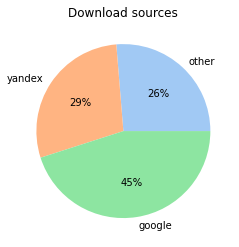

In [6]:
colors = sns.color_palette('pastel')
labels = mobile_sources['source'].unique()

plt.title('Download sources')
plt.pie(mobile_sources.groupby('source')['user.id'].count(), colors = colors, labels=labels, autopct='%.0f%%')
plt.show()

#### 2.2 What steps can users perform in the app?

In [48]:
print(mobile_dataset['event.name'].unique())

['advert_open' 'tips_show' 'map' 'contacts_show' 'search_4' 'search_5'
 'tips_click' 'photos_show' 'search_1' 'search_2' 'search_3'
 'favorites_add' 'contacts_call' 'search_6' 'search_7' 'show_contacts']


In [8]:
#let's merge search_1-search_7 steps under "search"
mobile_dataset['event.name'] = mobile_dataset['event.name'].str.replace(r'search.*', 'search', regex=True)

In [7]:
#let's merge duplicated events 'contacts_show' and 'show_contacts'
mobile_dataset['event.name'] = mobile_dataset['event.name'].str.replace('show_contacts', 'contacts_show')

In [51]:
#let's check unique values again
print(mobile_dataset['event.name'].unique())

['advert_open' 'tips_show' 'map' 'contacts_show' 'search' 'tips_click'
 'photos_show' 'favorites_add' 'contacts_call']


In [9]:
#download the data for Tableau
mobile_dataset.to_csv('mobile_dataset.csv')

The users can perform the following steps in the application:
`advert_open`,`tips_show`,`map`, `contacts_show`, `search`, `tips_click`,`photos_show`,`favorites_add` and `contacts_call`.

From the task description we also know that `contacts_show` key feature step can be followed after different steps in different combinations.

#### 2.3 What is the average and median session duration?

In [10]:
#lets exctract the date
mobile_dataset['event.date'] = pd.to_datetime(mobile_dataset['event.time']).dt.strftime('%Y-%m-%d')

In [11]:
#define sessions and calculate their duration in seconds
sessions = mobile_dataset.groupby(['user.id','event.date']).agg(
    {'event.time': ['min','max']}).reset_index()
sessions.columns = ['user.id', 'event.date','begin','end']
sessions['duration'] = sessions['end'] - sessions['begin']
sessions['duration'] = sessions['duration'].apply(lambda x: x.seconds)

display(sessions.head())

display(sessions.groupby('user.id')['duration'].mean().describe())

print('Mean session duration: {:.0f} мин.'.format(3759.625821/60))
print('Median session duration: {:.0f} мин.'.format(986.6/60))

user.id  event.date  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-22   
4  00157779-810c-4498-9e05-a1e9e3cedf93  2019-10-19   

                       begin                        end  duration  
0 2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617       595  
1 2019-10-09 18:33:55.577963 2019-10-09 18:42:22.963948       507  
2 2019-10-21 19:52:30.778932 2019-10-21 20:07:30.051028       899  
3 2019-10-22 11:18:14.635436 2019-10-22 11:30:52.807203       758  
4 2019-10-19 21:34:33.849769 2019-10-19 21:59:54.637098      1520

count     4293.000000
mean      3759.625821
std       7633.967044
min          0.000000
25%        367.000000
50%        986.600000
75%       3222.000000
max      84643.000000
Name: duration, dtype: float64

Average session duration: 63 мин.
Median session duration: 16 мин.


As we don't have session id we will calculate a session duration as the difference in time between the first and the last step performed for every user. The mean session duration is about one hour, and the median is 16 minutes.

#### 2.4 How many users performed the key event? What percentage of the total amount of users do they comprise?

In [12]:
print('Number of users who performed the key feature step')
print(mobile_dataset[mobile_dataset['event.name']== "contacts_show"]['user.id'].nunique())
print('Percentage of the total users:')
print((mobile_dataset[mobile_dataset['event.name']== "contacts_show"]['user.id'].nunique()/len(mobile_sources)*100))

Number of users who performed the key feature step
981
Percentage of the total users:
22.851153039832283


981 users used `contacts_show` key feature, which is 23% of the total users.

#### 2.5 Calculation of retention rate, DAU\WAU for the key feature step

In [13]:
#calculate the time when a user performed the first step
first_ts_key = mobile_dataset.groupby('user.id')['event.time'].min().to_dict()
mobile_dataset['first'] = mobile_dataset['user.id'].map(first_ts_key)

#extract weeks when the current and the first steps were performed
mobile_dataset['event_week']  = mobile_dataset['event.time'].dt.strftime('%W').astype(int)
mobile_dataset['first_event_week']  = mobile_dataset['first'].dt.strftime('%W').astype(int)

#calculate the lifetime of every user in weeks
mobile_dataset['lifetime'] = mobile_dataset['event_week'] - mobile_dataset['first_event_week']


#build a retention table
retention_pivot = mobile_dataset.pivot_table(
    index='first_event_week', columns='lifetime', values='user.id', aggfunc='nunique'
)
print('Retention table:')
display(retention_pivot)

#calculate the cohort size
cohort_sizes = (
    mobile_dataset.groupby('first_event_week')
    .agg({'user.id': 'nunique'})
    .rename(columns={'user.id': 'cohort_size'})
)
print('Cohort sizes:')
display(cohort_sizes)

#merge cohort sizes and retention tables
result_grouped = cohort_sizes.merge(
    retention_pivot, on='first_event_week', how='left'
).fillna(0)

#calculate retention rate
result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

print('Retention Rate in weekly cohorts:')
display(result_grouped)

Retention table:


lifetime               0      1      2      3
first_event_week                             
40                1130.0  272.0  170.0  119.0
41                1166.0  282.0  155.0    NaN
42                1094.0  239.0    NaN    NaN
43                 903.0    NaN    NaN    NaN

Cohort sizes:


cohort_size
first_event_week             
40                       1130
41                       1166
42                       1094
43                        903

Retention Rate in weekly cohorts:


0         1         2        3
first_event_week                                  
40                1.0  0.240708  0.150442  0.10531
41                1.0  0.241852  0.132933  0.00000
42                1.0  0.218464  0.000000  0.00000
43                1.0  0.000000  0.000000  0.00000

Text(0, 0.5, 'Number of unique users')

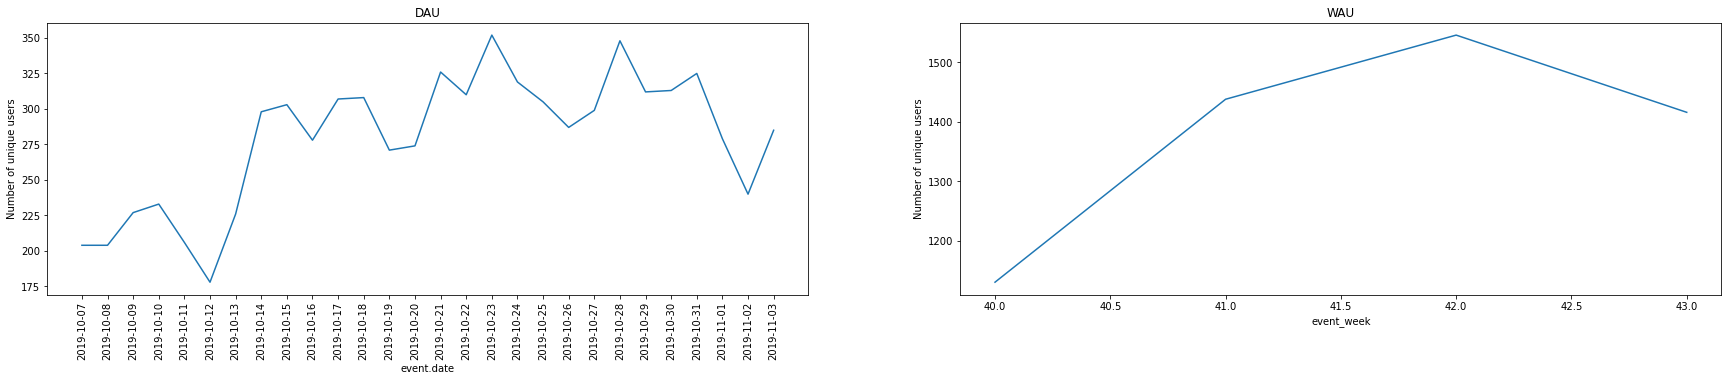

In [14]:
#calculate DAU\WAU

fig, axs = plt.subplots(1, 2, figsize=(30, 5))

ax = sns.lineplot(data=mobile_dataset.groupby('event.date').agg({'user.id':'nunique'}),color='#95d591',
                  legend=False,ax=axs[0])
ax.set_title('DAU')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of unique users') 

ax = sns.lineplot(data=mobile_dataset.groupby('event_week').agg({'user.id':'nunique'}), color='#95d591', 
                  legend=False, ax=axs[1])
ax.set_title('WAU')
ax.set_ylabel('Number of unique users') 


The retention rate for users in weekly cohorts varies from 10 to 24% depending on the lifetime. The number of unique users on average increases during the whole study period and decreases after the third week. There are big drops in DAU chart on 12.10.2019 and 02.11.2019.

<a id='3'></a>
### 3. Analysis of contacts_show key feature

#### 3.1 What other steps do users that performed the key feature step perform?

In [15]:
#extract users that performed contacts_show key feature step
key_users = mobile_dataset[mobile_dataset['event.name']== "contacts_show"]['user.id'].unique()

mobile_dataset_key = mobile_dataset[mobile_dataset['user.id'].isin(key_users)]

display(mobile_dataset_key.groupby('event.name').agg({'user.id':'count'}).reset_index().sort_values(by='user.id', ascending=False))

event.name  user.id
8      tips_show    12768
2  contacts_show     4529
5    photos_show     3828
6         search     2084
0    advert_open     1589
4            map     1101
1  contacts_call      541
3  favorites_add      424
7     tips_click      333

We can see that the users who performed the `contacts_show`key feature most frequently also performed `tips_show`step and less frequently -  `photos_show`, `search`,`advert_open` and others. 

However, `tips_show` step was shown to all the users, that is why we will not consider it in the future analysis. 
`tips_click`, `favorites_add`,`contacts_call` steps were performed less often.

### 3.2 What steps do the users perform before the key feature step (what are the scenarios of app usage)?

In [16]:
#calculate the time when the key feature step was performed for each user for every day and add it to the table
key_time=mobile_dataset_key[mobile_dataset_key['event.name']== "contacts_show"].groupby('user.id')['event.time'].min()

mobile_dataset_key['contacts_show_first'] = mobile_dataset_key['user.id'].map(key_time)

#calculate the difference in second between the key feature step and the previous/next step
mobile_dataset_key['diff'] = (mobile_dataset_key['contacts_show_first'] - mobile_dataset_key['event.time'])
mobile_dataset_key['diff'] = mobile_dataset_key['diff'].astype('timedelta64[m]').astype(np.int32)


#see if any users performed only the key feature step
print('Number of users who performed the key feature event immediately:')
display(mobile_dataset_key.pivot_table(index='event.name', columns='user.id', 
                                       values='event.time', aggfunc='nunique').reset_index()
                                        .drop('event.name', axis=1)
                                        .isnull().any(axis=1).sum())

Number of users who performed the key feature event immediately:


8

In [17]:
#lets only have the previous steps in the dataset
mobile_dataset_key_before = mobile_dataset_key.query('diff > 0')

#extract the events that users did prior to the key feature step
key_before = mobile_dataset_key_before.groupby('user.id')['event.name','event.time'].min('diff').reset_index()
display(key_before.groupby('event.name').agg({'user.id':'count'}).reset_index().sort_values('user.id', ascending=False))

event.name  user.id
3    photos_show      191
6      tips_show      177
2            map      148
4         search      100
0    advert_open       74
1  favorites_add       38
5     tips_click       13

We see that prior to the key feature step the users mostly performed `photos_show`, `tips_show` and `map`. Only 8 users performed the key feature step immediately.

#### 3.3 After how much time after the last step from p.3.2 is the key feature step performed?

Время до совершения целевого события без разбивки по дням
count      741.000000
mean      2338.066127
std       5094.943756
min          1.000000
25%          6.000000
50%         33.000000
75%       1523.000000
max      33380.000000
Name: diff, dtype: float64

Time to key feature step by days
count     504.000000
mean       56.323413
std       137.983981
min         1.000000
25%         4.000000
50%        10.000000
75%        34.250000
max      1183.000000
Name: diff, dtype: float64


Text(0.5, 0, 'Minutes')

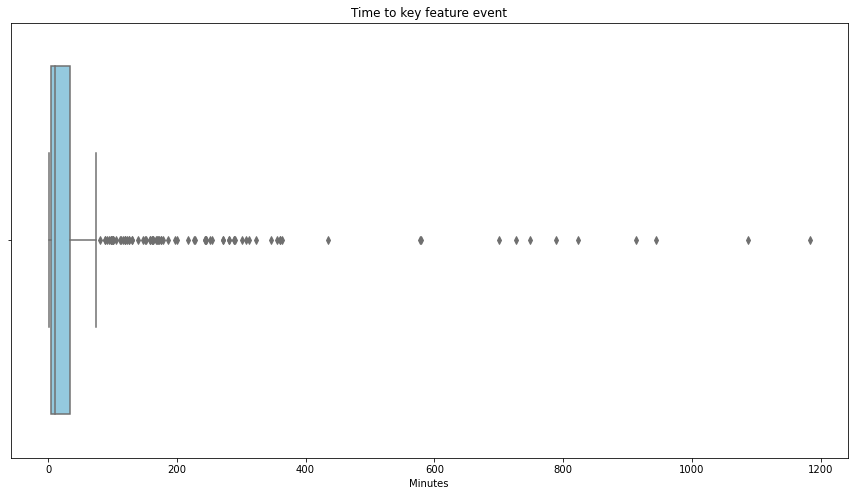

In [18]:
key_before['contacts_show_first'] = key_before['user.id'].map(key_time)
key_before['diff'] = (key_before['contacts_show_first'] - key_before['event.time'])
key_before['diff'] = key_before['diff'].astype('timedelta64[m]').astype(np.int32)

print('Время до совершения целевого события без разбивки по дням')
print(key_before['diff'].describe())
print()

#only consider the steps that were performed the same day as the key feature step
key_before['event.date'] = pd.to_datetime(key_before['event.time']).dt.strftime('%Y-%m-%d')
key_before['contacts_show_firs.date'] = pd.to_datetime(key_before['contacts_show_first']).dt.strftime('%Y-%m-%d')
key_before_same_day = key_before[key_before['event.date'] == key_before['contacts_show_firs.date']]

print('Time to key feature step by days')
print(key_before_same_day['diff'].describe())

plt.figure(figsize=(15,8))
ax = sns.boxplot(x=key_before_same_day['diff'],color='skyblue')
ax.set_title('Time to key feature event')
ax.set_xlabel('Minutes') 

As a result of `contacts_show` key feature we have discovered the following:
1. The users mostly perform `photos_show`, `search`, `advert_open` and other steps along with the key feature step.

2. Only 8 users immediately jumped to `contacts_show`. The most frequent previous steps are `photos_show`, `tips_show` and `map`.

3. If we look at one day period, the average time between the `contacts_show` and the previous step is 50 minutes. As we can see on the graph there are outliers, that is why we should consider using the median time instead, which is 8 minutes. 75% of users performed the key feature step in 34 minutes.

<a id='4'></a>
### 4. Hypothesis test

#### 4.1 Conversion to see contacts is different among users who perform both tips_show and tips_click and users who only perform tips_show.

In [19]:
#statistical significance level
alpha = .05

In [20]:
#define users who performed the tips_show step AND the key feature step
tips_show_users = mobile_dataset[mobile_dataset['event.name'] == 'tips_show']['user.id'].unique()
tips_show_users_df = mobile_dataset[mobile_dataset['user.id'].isin(tips_show_users)]
print('Number of unique users who performed tips_show step:')
print(len(tips_show_users))
print('Number of unique users who performed both tips_show step AND contacts_show:')
print(len(tips_show_users_df[tips_show_users_df['event.name'] == 'contacts_show']['user.id'].unique()))

print()

#выделим пользователей, которые совершили события и tips_show и tips_click
tips_show_click_users = tips_show_users_df[tips_show_users_df['event.name'] == 'tips_click']['user.id'].unique()
tips_show_click_users_df = mobile_dataset[mobile_dataset['user.id'].isin(tips_show_click_users)]  
print('Number of unique users who performed both tips_show AND tips_click:')
print(len(tips_show_click_users))
print('Number of unique users who performed both tips_show AND tips_click AND contacts_show:')
print(len(tips_show_click_users_df[tips_show_click_users_df['event.name'] == 'contacts_show']['user.id'].unique()))

print()

#two-sided z-test
count1 = np.array([516, 91])
nobs1 = np.array([2801, 297])
stat1, pval1 = proportions_ztest(count1, nobs1, alternative='two-sided')

print('P-value: {}'.format(pval1))
print('Test statistic: {0:0.3f}'.format(stat1))

if pval1 < alpha:
    print("Reject null hypothesis")
else:
    print("Could not reject the null hypothesis")

Number of unique users who performed tips_show step:
2801
Number of unique users who performed both tips_show step AND contacts_show:
516

Number of unique users who performed both tips_show AND tips_click:
297
Number of unique users who performed both tips_show AND tips_click AND contacts_show:
91

P-value: 4.55621837828025e-07
Test statistic: -5.044
Reject null hypothesis


<b>H0: The convertion to contacts_show among users who perform both tips_show and tips_click steps is the same as among users who only perform tips_show </b> 

P-value is less than the critical value, therefore, we reject the null hypothesis at 5% significance level.

#### 4.2 Conversion to see contacts is different among users who downloaded the app from yandex source and google source.

In [21]:
#define users who installed the app from source yandex
yandex_users = mobile_sources[mobile_sources['source'] == 'yandex']['user.id'].unique()
yandex_users_df = mobile_dataset[mobile_dataset['user.id'].isin(yandex_users)]
print('Number of unique users who installed the app from source yandex')
print(len(yandex_users))
print('Number of unique users who installed the app from source yandex and performed the key feature step contacts_show:')
print(len(yandex_users_df[yandex_users_df['event.name'] == 'contacts_show']['user.id'].unique()))

print()

#define users who installed the app from source google
google_users = mobile_sources[mobile_sources['source'] == 'google']['user.id'].unique()
google_users_df = mobile_dataset[mobile_dataset['user.id'].isin(google_users)]
print('Number of unique users who installed the app from source google:')
print(len(google_users))
print('Number of unique users who installed the app from source google and performed the key feature step contacts_show:')
print(len(google_users_df[google_users_df['event.name'] == 'contacts_show']['user.id'].unique()))

print()

#two-sided z-test
count2 = np.array([478, 275])
nobs2 = np.array([1934, 1129])
stat2, pval2 = proportions_ztest(count2, nobs2, alternative='two-sided')

print('P-value: {0:0.3f}'.format(pval2))
print('Test statistic: {0:0.3f}'.format(stat2))

if pval2 < alpha:
    print("Reject null hypothesis")
else:
    print("Could not reject the null hypothesis")


Number of unique users who installed the app from source yandex
1934
Number of unique users who installed the app from source yandex and performed the key feature step contacts_show:
478

Number of unique users who installed the app from source google:
1129
Number of unique users who installed the app from source google and performed the key feature step contacts_show:
275

P-value: 0.824
Test statistic: 0.222
Could not reject the null hypothesis


<b>H0:The conversion to contacts_show is equal between users who downloaded the app from google and from yandex.</b> 

P-value is more than the critical value, therefore, we can not reject the null hypothesis at 5% significance level.

<a id='5'></a> 
### 5. Conclusion

We have performed an analysis of user behaviour in the "Unnecessary things" mobile app. 4293 users used the app from October 7th 2019 to November 3rd 2019.

As a result of our study we found the following:

1. About 45% of users downloaded the application from the source `google`, 20% from `yandex`, and the remaining - from other sources. 

2. The median session duration is 16 minutes.

3. `contacts_show` key feature step was performed by 23% of users.

4. The retention rate for users divided by weekly cohorts is 10-24%. The number of unique users on average increases during the study period and decreases only after the third week. 

The analysis of the `contacts_show` key feature shows that only 8 users directly jumped to the `contacts_show` step. The most frequent preceding events are  `photos_show`, `tips_show` and `map`. The median time before the user goes to `contacts_show` is 8 minutes, and 75% of users go to `contacts_show` 34 minutes after the current step.

In general, the users who opened the `contacts_show` feature, also often went through `photos_show`, `search` and `advert_open` and other steps.

As a result of A/B tests, we discovered that we can reject the null hypothesis that the conversion to `contacts_show` among users who perform both `tips_show` and `tips_click` steps is the same as among users who only perform `tips_show`. We also can not reject the hypothesis that the conversion to `contacts_show` is equal between users who downloaded the app from `google` and `yandex`.

In conclusion, we could provide the following recommendations:
1. As from the А/В test we found out that the conversion to the key feature step does not differ among users from 
`google` and `yandex` sources, therefore we could think bout cutting expenses for one of the sources.

2. Only 23% of users used the `contacts_show` feature. Probably, one should study the `tips_click` step and understand why it is not in any of the feature scenarios; maybe the problem is in the `tips_click` step UI.